# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lets_plot import *

In [2]:
# from datalore.display import *

In [3]:
from matplotlib.image import imread

In [4]:
from scipy.stats import uniform, norm, geom, mannwhitneyu, ks_2samp
from scipy.linalg import cholesky

In [5]:
from copy import copy
import time

In [6]:
from PIL import Image

In [7]:
import seaborn as sns

$\newcommand{\pr}{\mathbb{P}}$

In [8]:
def square_loss(y, X, beta):
    r = y - X.dot(beta)
    return (r**2).sum()

In [9]:
def eval_score(model, val, y_val):
    y_hat = model(val).squeeze()
    y_val = y_val.squeeze()
    return 1. - ((y_val-y_hat)**2).mean()/np.var(y_val)

In [10]:
def clip(x, min_x, max_x):
    x_ = copy(x)
    x_[x_ < min_x] = min_x
    x_[x_ > max_x] = max_x
    return x_

In [11]:
def plot_map(data, zoom=6, legend=True):
    plot = ggplot(data=data)\
        + geom_livemap(zoom=zoom)\
        + geom_point(mapping=aes(x='Longitude',
                                 y='Latitude', 
                                 color='target'),alpha=0.1)\
        + scale_color_gradient(low='blue', high='red') + ggsize(500, 500)
    if not legend:
        plot += theme(axis_text='blank', axis_ticks='blank', axis_line='blank', axis_title='blank', legend_position='none')
    return plot

In [12]:
def plot_digit(digit, caption=None, n=28):
    digit = digit.reshape(n, n)
    digit = (digit - np.min(digit))/(np.max(digit) - np.min(digit))
    p = ggplot() + geom_image(image_data=digit) + labs(x='', y='') \
        + theme(axis_line='blank', axis_title='blank', axis_ticks='blank', axis_text='blank')
    if caption:
        p += ggtitle(caption)
    return p;

# numpy

# Problem 1 (0.5)
Taking some non-linear function $g$ you can transform any given distribution to another distribution with non-trivial form.
Let's start from normal distributed value $z$. Suppose $z\in\mathbb{R}^2$, consider the function $\displaystyle g(z)=C\frac{z}{\|z\|_{\alpha}}+\frac{z}{s}$.
$\color{blue}{\text{Fill in the implementation of the function}}$ `g(z, C, ord, scale)` $\color{blue}{\text{below.}}$

In [13]:
def g(z, C=2.5, ord=2, scale=10):
    """
    Args: 
      z - function argument
      C - first scalling constant
      ord - norm order defined as alpha
      scale - second scalling coefficient
    Returns:
      vectorized resulting value
    """
    # YOUR CODE (START)
    result = np.array([(C / np.linalg.norm(item, ord) + 1 / scale) * item for item in z])
    # YOUR CODE (END)
    return result

In [14]:
x = np.random.normal(loc=0, scale=1, size=(1000, 2))
y = g(x, ord=np.inf)
data = pd.DataFrame(x, columns=['x1', 'x2'])
data['y1'], data['y2'] = y[:,0], y[:,1]

In [15]:
ggplot(data) \
        + geom_point(aes(x='x1', y='x2'), color='blue') \
        + geom_point(aes(x='y1', y='y2'), color='red') \
        + ylim(-3,3) + xlim(-3,3)

# Problem 2 (1.0)

#### K-means

Consider a set of examples $\{x^{(1)},\ldots,x^{(m)}\}$. Our task is to cluster this examples. 

Algorithm:
* Set randomly cluster centroids $\mu_1,\ldots,\mu_k$;
* Repeat until convergence
  * For each $i$ define $$c^{(i)}=\arg\min_j\|x^{(i)}-\mu_j\|^2$$
  * For each $j$ set $$\mu_j=\frac{\sum_{i=1}^m1_{\{c^{(i)}=j\}}x^{(i)}}{\sum_{i=1}^m1_{\{1_{c^{(i)}=j}\}}}$$ 

The loss function is $$J(c,\mu)=\sum_{i=1}^m\|x^{(i)}-\mu_{c^{(i)}}\|^2$$

**TASK** Consider image `boat.jpg` - as a tensor of size `(225, 225, 3)`. Each of the three channels defines pixel's color intencity (red, green, blue). Intencities are in the range (0, 255). Use K-means to represent the image in 16 colors.



In [16]:
X = imread('boat.jpg')

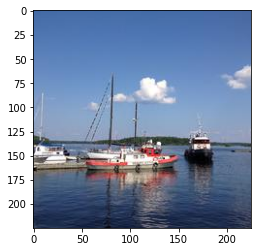

In [17]:
plt.imshow(X)

In [18]:
# число цветов (кластеров) задано и равно 16
n_components = 16

In [19]:
# создаем случайный центроид (для инициализации)
def random_centroid():
    return np.random.choice(np.arange(0,255), size=3)

In [20]:
# функция вычисления расстояния между точками
def euclidean_distances(x, y):
    r = x - y
    return np.sqrt((r ** 2).sum())

In [21]:
# вычисление текущих значений центроидов - вычисление mu_j
def cluster_means(X, y, n_components):
    # напишите здесь ваш код

    mu = [[0] * len(X[0][1]) for i in range(n_components)]
    mu_n = [0 for i in range(n_components)]

    for i in range(len(X)):
        for j in range(len(X[i])):
            mu_n[y[i][j]] += 1
            for o in range(3):
                mu[y[i][j]][o] += X[i][j][o]

    for i in range(n_components):
        if mu_n[i] != 0:
            mu[i] = [j / mu_n[i] for j in mu[i]]

    return mu


In [22]:
# вычисление ближайшего центроида для i-ой точки - вычисление c^{(i)} 
def update_encoder(X, mu):
    # напишите здесь ваш код

    n = X.shape[0] * X.shape[1]
    y = np.random.choice(n_components, n).reshape(X.shape[0], X.shape[1])

    for i in range(len(X)):
        for j in range(len(X[i])):
            cur_min = 1e20
            for o in range(len(mu)):
                min_tmp = euclidean_distances(X[i][j], mu[o])
                if min_tmp < cur_min:
                    cur_min = min_tmp
                    y[i][j] = o

    return y

In [23]:
# итерации алгоритма К-средних
def kmeans(X, iterations=10):
    n = X.shape[0] * X.shape[1]
    y = np.random.choice(n_components, n).reshape(X.shape[0], X.shape[1])
    for _ in range(iterations):
        mu = cluster_means(X, y, n_components)
        y = update_encoder(X, mu)
    return mu

In [24]:
# рассчитаем центроиды кластеров
mu = kmeans(X, 10)


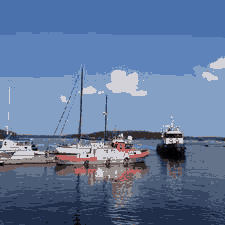

In [25]:
# этот скрипт отобразит сжатое изображение когда напишите функции cluster_means и update_encoder
mask = update_encoder(X, mu)
if mask is not None:
    compressed = np.array(mu, dtype=np.uint8())[mask.reshape(-1)].reshape(X.shape)
    res = ggplot() + geom_image(compressed) + theme(axis_line='blank', axis_title='blank', axis_ticks='blank', axis_text='blank')
    res.show()

# Problem 3 (1.0)

Implement `unmixer` function below (see notes in function definition).

### Independent Component Analysis
Suppose we have some input signals denoted $z\in\mathbb{R}^n$, which we can't observe directly. 
Instead we observe $x=Az$, where $A$ is unknown **mixing matrix**.

Suppose we have a set of observations $\{x^{(i)}, i=1,\ldots, m\}$ and we want to reconstruct the initial inputs $z^{(i)}$, where $x^{(i)}=Az^{(i)}$.

Denote $W=A^{-1}$ the **unmixing matrix**, then our goal is to find $W$ and reconstruct inputs $z^{(i)}=Wx^{(i)}$. 
Denote also $w_j^T$ - the j-th row of $W$, then $\displaystyle z_j^{(i)}=w_j^Tx^{(i)}$ 

### Non-Gaussian inputs
Suppose $z\sim N(0, I)$, where $I\in\mathbb{R}^{2\times 2}$, then $x=Az$ is also Gaussian with zero mean and covariance matrix
$$\mathbb{E}(xx^T)=\mathbb{E}\left(Azz^TA^T\right)=AA^T$$
Suppose now that $R$ is orthogonal matrix: $RR^T=R^TR=I$ and denote $A^{\prime}=AR$.
Consider $A^{\prime}$ as mixing matrix and get observation $x^{\prime}=A^{\prime}z$.
The obtained $x^{\prime}$ is also Gaussian with zero mean and covariance
$$\mathbb{E}\left(x^{\prime}(x^{\prime})^T\right)=\mathbb{E}\left(A^{\prime}zz^T(A^{\prime})^T\right)=\mathbb{E}\left(ARzz^T(AR)^T\right)=AA^T$$
Hence for two different mixing matrices $A$ and $A^{\prime}$ we obtain the same output distribution $N(0, AA^T)$

### Linear transformations of densities
Suppose we have random variable $z$ from some density $p_z(z)$, where $z\in\mathbb{R}$ and $x=Az$, where $x, A \in\mathbb{R}$.
What is the density of $x$?

Denote $W=A^{-1}$, then we have
$$\boxed{\;p_x(x)=p_z(Wx)\cdot|W|\;}$$ 

### ICA algorithm
Let's introduce the notation for the joint distribution
$$p(z)=\prod_{j=1}^np_z(z_j)$$
Suppose, that inputs are independent and derive the joint density for $x=Az=W^{-1}z$:
$$p(x)=\prod_{j=1}^n p_z(w_j^Tx)\cdot|W|$$
Now we have to specify densities $p_z$. Let's take some non-Gaussian cdf - sigmoid function $\displaystyle g(z)=\frac{1}{1+\exp(-z)}$ and take $\displaystyle p_z(z)=g^{\prime}(z)$
The unmixing matrix $W\in\mathbb{R}^{n\times n}$ is the model parameter. We get the log-likelihood:
$$\ell(W)=\sum_{i=1}^m\left(\sum_{j=1}^n\log g^{\prime}(w_j^Tx^{(i)})+\log|W|\right)$$
Using the formula for matrix derivatives
$$\nabla_W|W|=|W|\left(W^{-1}\right)^T$$
we obtain the gradient ascent update rule (**FORMULA A**):
$$W=W+\alpha\left(\left[
\begin{array}{c}
1-2g(w_1^Tx^{(i)})\\
\vdots\\
1-2g(w_n^Tx^{(i)})
\end{array}\right](attachment:./x^{(i)})^T+(W^T)^{-1}\right)$$
with $\alpha$ - learning rate.

In [26]:
X = pd.read_csv('mnist_data.csv').values[:, 1:]
y = pd.read_csv('mnist_target.csv').values[:, 1]

In [27]:
X = X/255

In [28]:
np.random.seed(43)
num_sources = 3

In [29]:
idx = np.random.randint(X.shape[0], size=num_sources)

In [30]:
image_mixed = np.sum(X[idx, :], axis=0)

In [31]:
A = np.random.uniform(size=num_sources**2).reshape(num_sources, num_sources)
sources = X[idx]
mixed_images = A.dot(sources)

In [32]:
bunch = GGBunch()
plot = plot_digit(mixed_images[0], 'Mixed image: '+str([int(y_) for y_ in y[idx]]))
bunch.add_plot(plot, 0, 0)
for step, i in enumerate(idx):
    plot = plot_digit(X[i, :], 'Initial image: '+str(int(y[i])))
    bunch.add_plot(plot, 350*(step+1), 0)
bunch.show()

In [33]:
def normalize(dat):
    return 0.99 * dat / np.max(np.abs(dat))

In [34]:
def g(x):
    return 1./(1. + np.exp(-x))

In [35]:
# TASK is HERE!
# NOTES: you are offered to implement a special variant of ICA algorithm:
# apply FORMULA A (gradient ascent updates) 
#  - with alphas from logspace(alpha_min, alpha_max);
#  - for each alpha take some x[i] from a permutation of X
def unmixer(X):
    M, N = X.shape
    W = np.eye(N)

    alphas = np.logspace(-1, -4)
    for alpha in alphas:
        # write your code here (BEGIN)
        for x_i in np.array(X):
            x_i = x_i.reshape(-1, 1)
            W += alpha * (np.dot((1 - 2 * g(np.dot(W, x_i).reshape(-1, 1))), x_i.T) + np.linalg.inv(W.T))
        # write your code here (END)

    return W

In [36]:
def unmix(X, W):
    S = X.dot(W.T)
    return S

In [37]:
W = unmixer(mixed_images.T)

In [38]:
S = normalize(unmix(mixed_images.T, W))

In [39]:
bunch = GGBunch()
plot = plot_digit(mixed_images[0], 'Mixed image: '+str([int(y_) for y_ in y[idx]]))
bunch.add_plot(plot, 0, 0)
for step, i in enumerate(idx):
    plot = plot_digit(S.T[step, :], 'Initial image: '+str(int(y[i])))
    bunch.add_plot(plot, 350*(step+1), 0)
bunch.show()

# Smirnov's Theorem

# Smirnov's Theorem
Let $\eta$ be a continuous r. v. with a c.d.f. $F$.

Define inverse function: $G(u)=\inf \{x: F(x)\geq u\}$,  $0 < u < 1$  inverse function for $F$: $ F(G(x))=x$,  $0<x<1$.

What is the distribution of r.v. $\xi = F(\eta)$? 
Notice, that $ 0\leq \xi\leq 1$. 
Derive the c.d.f. of $\xi$:

$H(x)=\pr\left(\xi\leq x\right)=\pr\left(F(\eta)\leq x\right)=\pr\left(\eta \leq G(x)\right)=F(G(x))=x,\quad 0<x<1 \quad \Rightarrow\quad \xi \sim U_{[0,1]}$.

How this can be used for modeling? 
Let $\xi \sim U_{[0,1]}$ and $G=F^{-1}$ - inverse for some c.d.f., then $\eta=G(\xi)\sim F$.

#### Empirical distribution
Suppose we have observations $x^{(1)}, \ldots,x^{(m)}$ from some probability distribution with cumulative distribution $F(x)$. We can define empirical distribution on the observed values $x^{(1)}, \ldots,x^{(m)}$
$$\hat{F}_m(x)=\frac{1}{m}\sum_{i=1}^m 1_{\{x^{(i)}\leq x\}}$$

# Problem 5 (0.5)
$\color{blue}{\text{Fill in the implementation of the function}}$ `cdf_xy(observations)` $\color{blue}{\text{which returns x and y coordinates for an empirical function built from observations.}}$

In [40]:
def cdf_xy(values):
    # YOUR CODE (START)
    x = sorted(np.array(values, copy=True))
    y = np.linspace(1 / len(values), 1, len(values))
    # YOUR CODE (END)
    return x, y

In [41]:
observations = np.random.normal(size=1000)

Now we can get $x$ and $y$ coordinates of the empirical function $\hat{F}_m(x)$ and construct an interpolation $\tilde{F}_m(x)$ with `np.interp` function and apply the resulting interpolated function to some distribution to get flattened version of it. We already know, what happens to normal distribution:

In [42]:
x, y = cdf_xy(observations)
equalized_dist = np.interp(observations, x, y)

In [43]:
data = pd.DataFrame({'x':x, 'y':y})

In [44]:
bunch = GGBunch()
plot = ggplot() + geom_histogram(aes(equalized_dist, y='..density..'), fill='blue', alpha=0.5, bins=50) + \
    geom_histogram(aes(observations, y='..density..'), fill='red', alpha=0.5) + \
    ggsize(400, 300) + ggtitle('Initial and flattened distributions')
bunch.add_plot(plot, 0, 0)
plot = ggplot(data) + geom_path(aes('x', 'y'), color='blue', size=1) + ggsize(400, 300) + ggtitle('Interpolated empirical cdf')
bunch.add_plot(plot, 400, 0)
bunch.show()

We can treat an image (flattened to a vector) as some "distribution" and apply the same technique to it. This approach is called "image equalization".

In [45]:
colored_image = np.array(Image.open("gateway.jpg"))
image = np.mean(colored_image, axis=2)/255
image_data = image


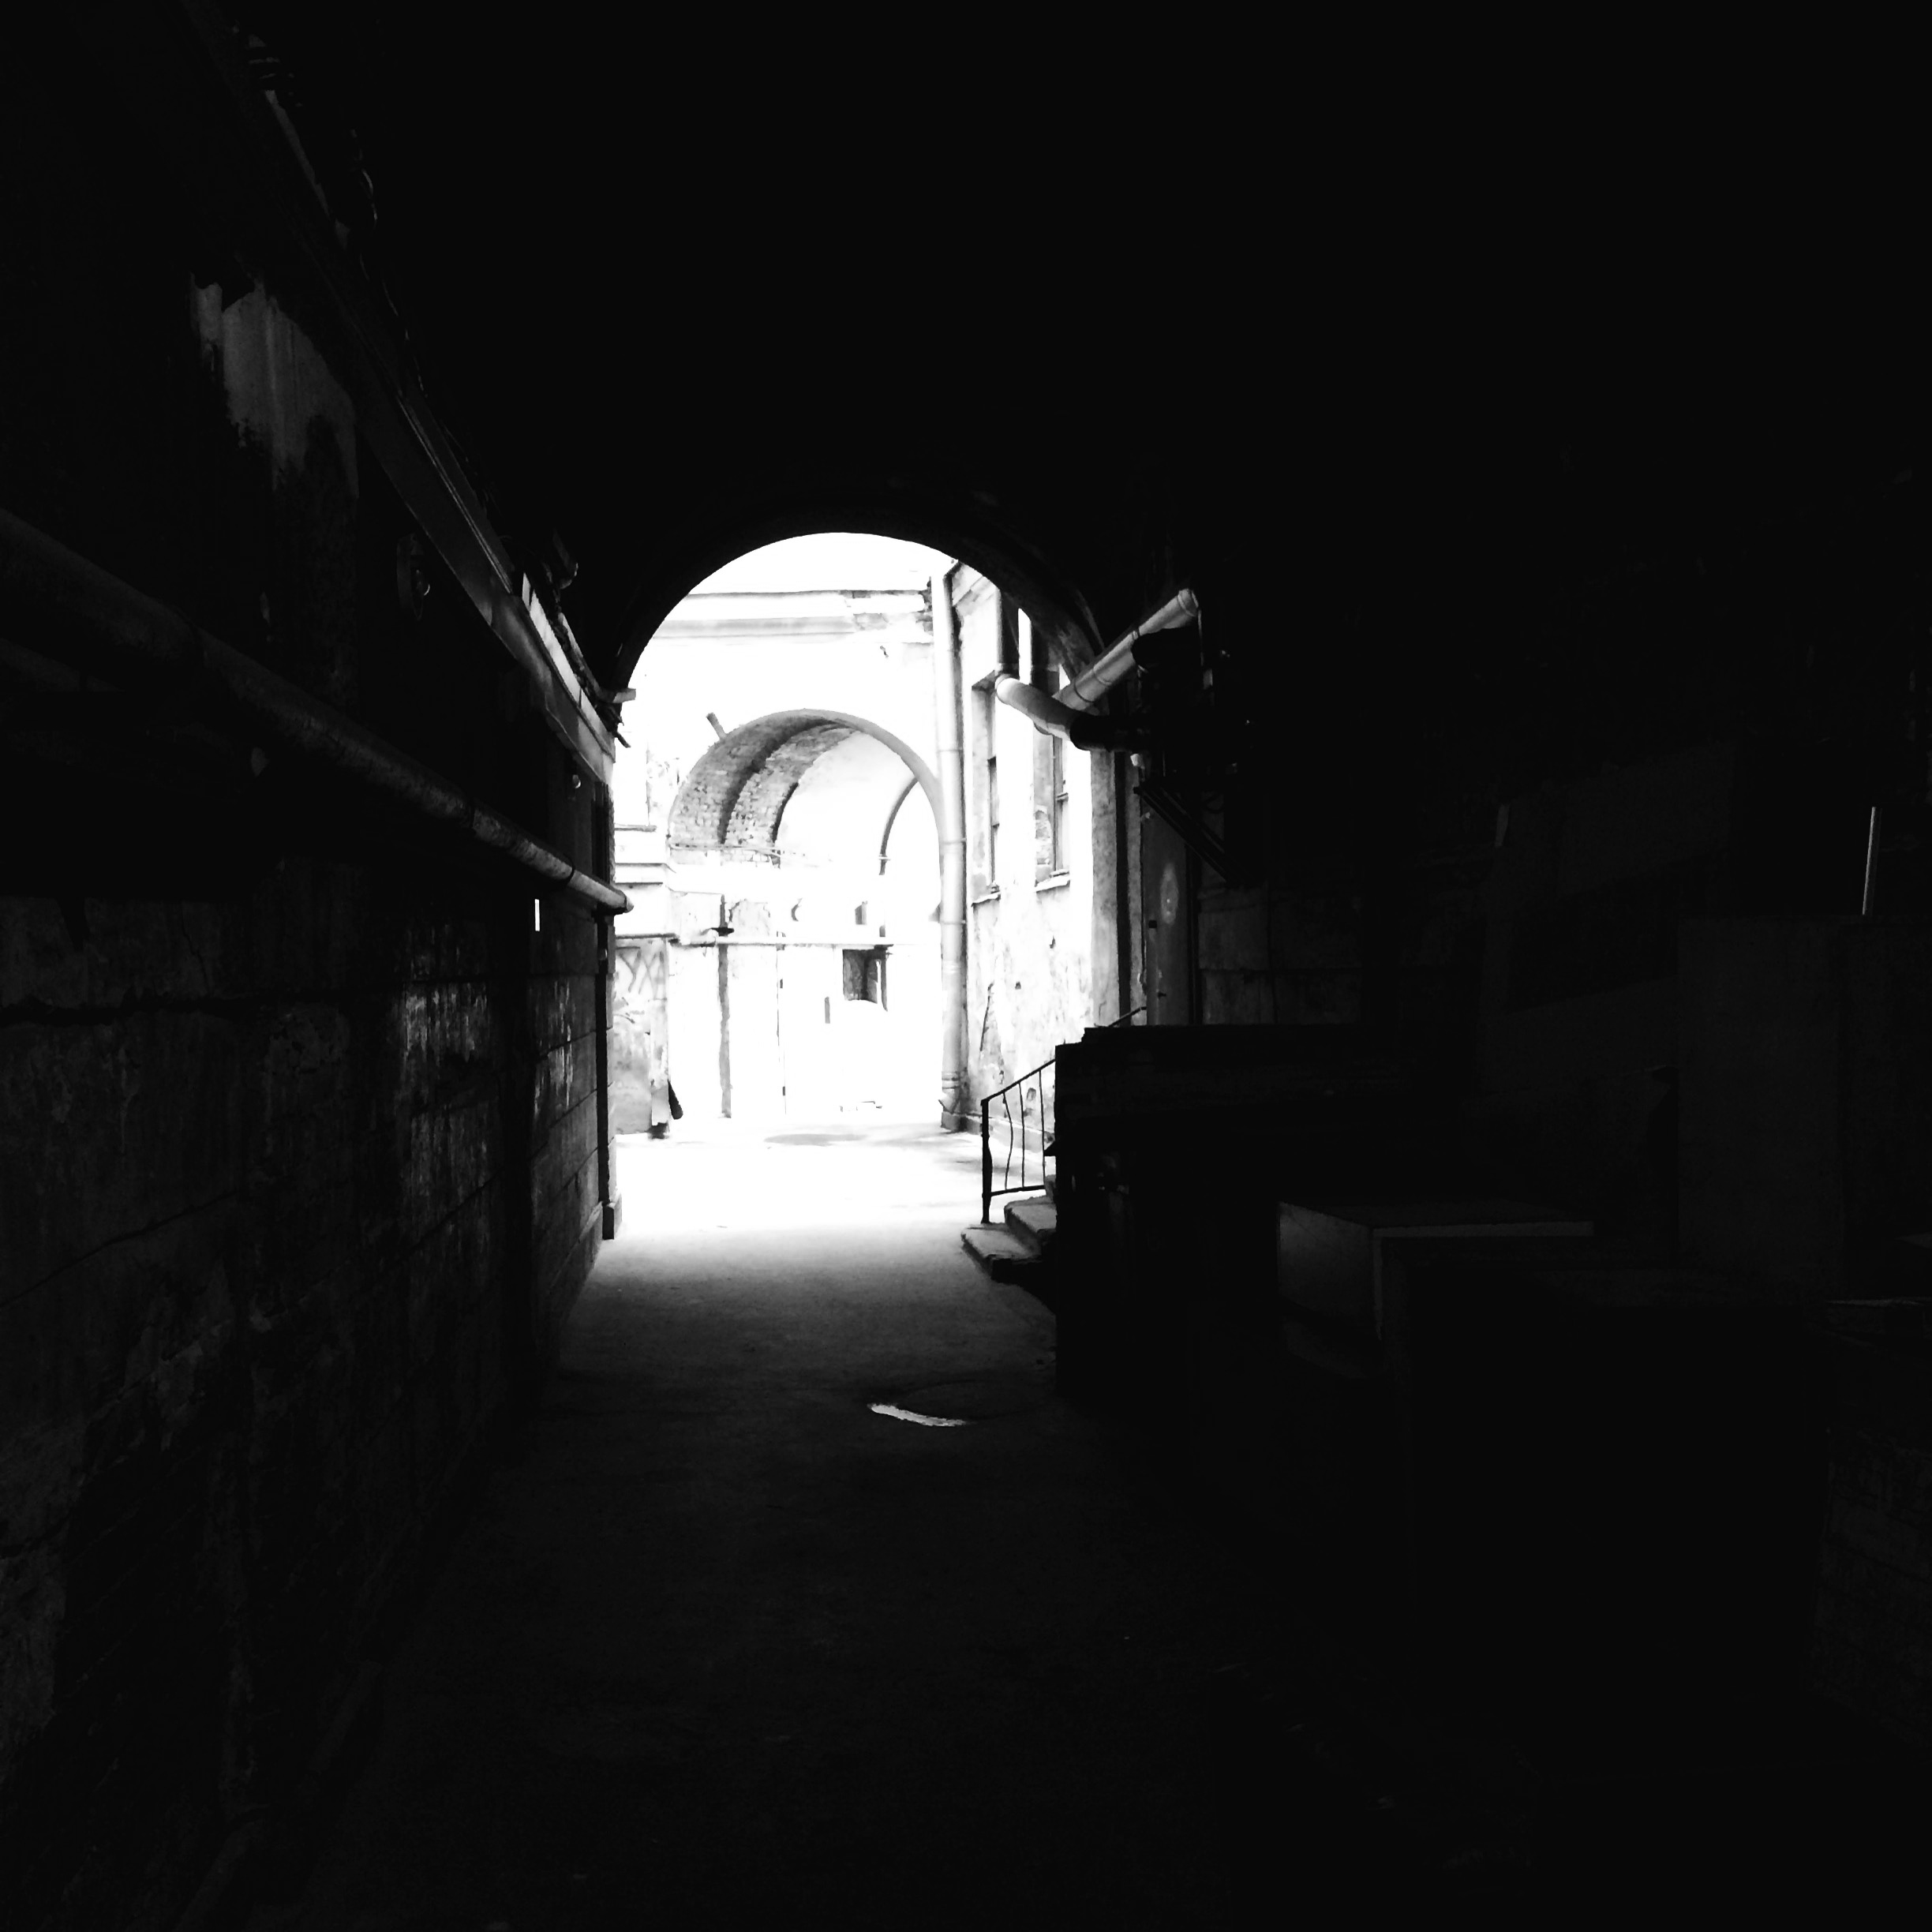

In [46]:
ggplot() + geom_image(image_data) + \
    theme(legend_position='none', axis_ticks='blank', axis_line='blank', axis_title='blank', axis_text='blank') + \
    ggtitle('Initial image')

In [47]:
flat = image.reshape(-1)
x, y = cdf_xy(flat)
equalized_image = np.interp(image, x, y)


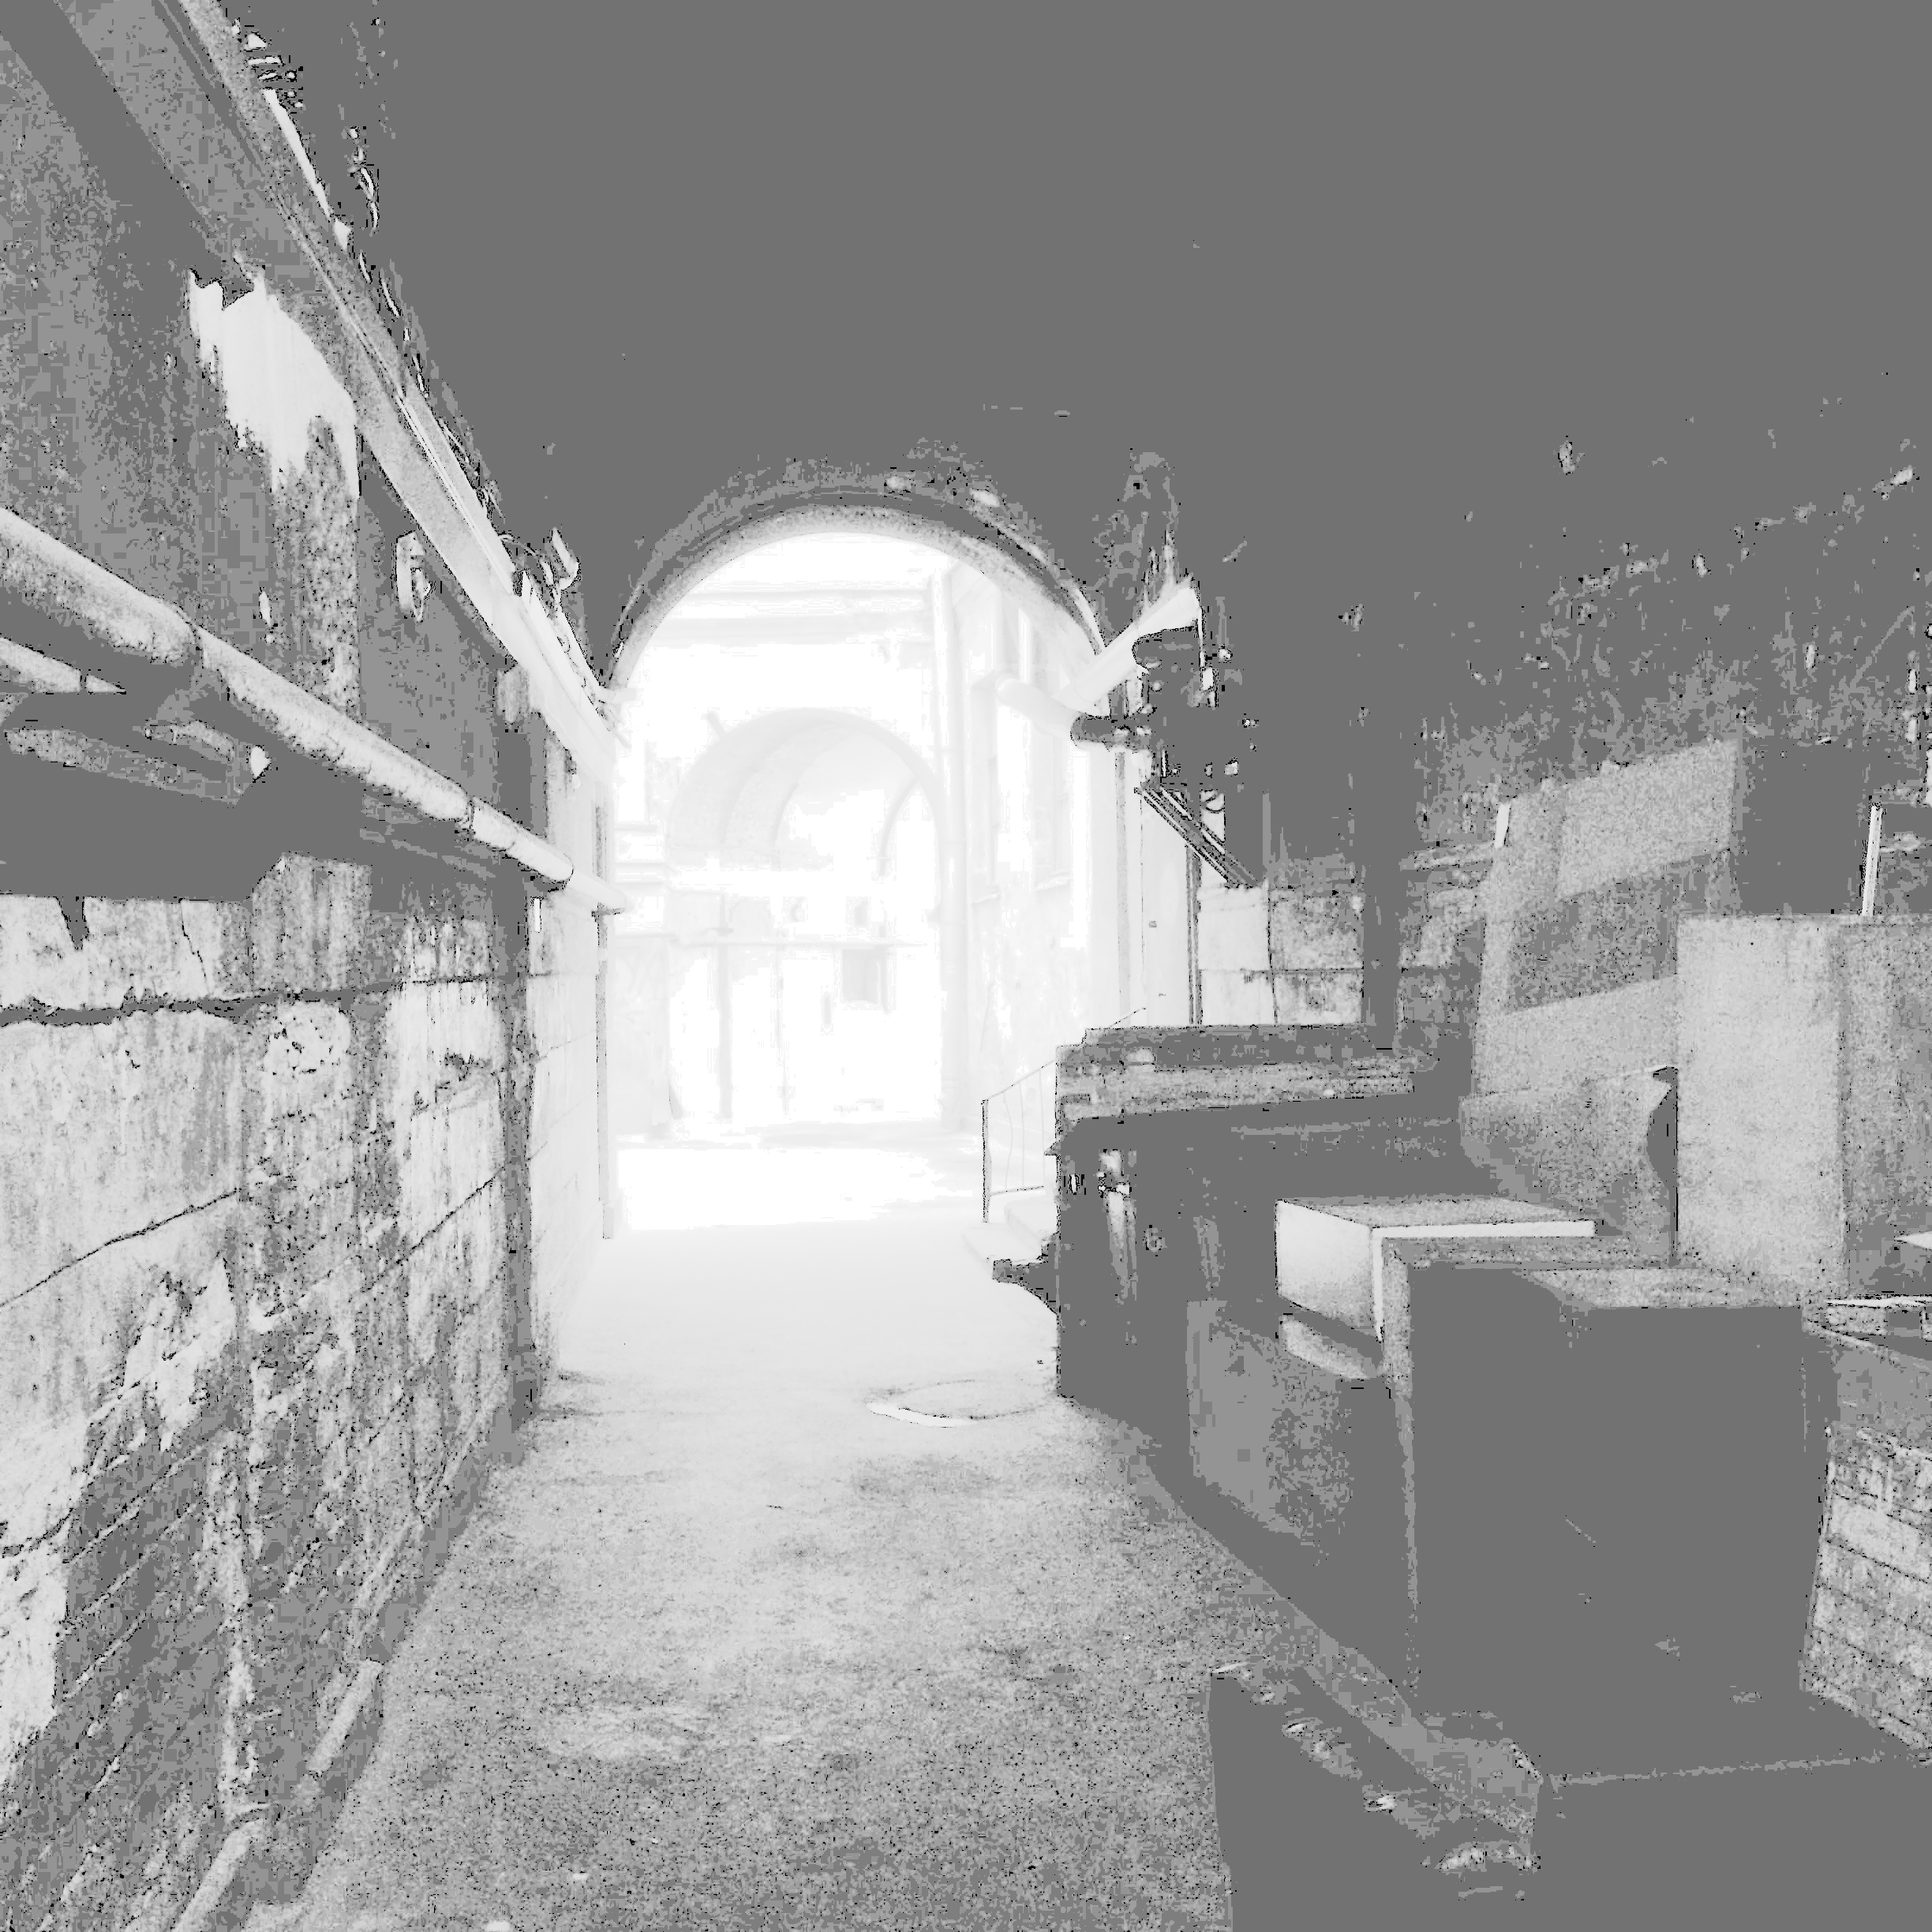

In [48]:
ggplot() + geom_image(image_data=equalized_image) + \
    theme(legend_position='none', axis_ticks='blank', axis_line='blank', axis_title='blank', axis_text='blank') + \
    ggtitle('Equalized image')

# SGD Linear Regression

# Problem 6 (1.0)
In this task we will solve linear regression problem with the help of batch gradient descent. We will build our model in a way similar to what is usually done in deep learning frameworks (like PyTorch or TensorFlow), which perform differentiation automatically. The main difference here will be that you'll implement the differentiation part writing formulas by yourself.

First, we read California housing data from the [StatLib repository](http://lib.stat.cmu.edu/datasets/) and saved it to a file.
Then we read data to a data frame and define feature matrix $X$ and target vector $y$. **Features** contain coordinates (lat, lon), house age, number of rooms, number of bedrooms, population in the area, number of households and average income. **Target** value is a log-cost of a house. We are going to build a model, which will predict the house cost by it's features.

In [49]:
class fetch_california_housing:
    def __init__(self, filename='cal_housing.data', scale_target=True):
        filedata = pd.read_csv(filename, header=None).values
        self.data = filedata[:, :-1]
        self.target = filedata[:, -1]
        if scale_target:
            self.target = self.target / 100000
        self.feature_names = [
            'Longitude',
            'Latitude',
            'housingMedianAge',
            'totalRooms',
            'totalBedrooms',
            'population',
            'households',
            'medianIncome'
        ]

In [50]:
housing = fetch_california_housing()
data = pd.DataFrame(housing.data, columns=housing.feature_names)
data['target'] = housing.target

In [51]:
X, y = housing.data, housing.target

We also removed the tail observations, containing house costs clipped to a value of 5 to avoid atoms in our distribution.

In [52]:
# remove tail observations clipped to the value 5
what_to_stay = (y < 5)
X, y = X[what_to_stay], y[what_to_stay]

Define the linear transformation coefficients - matrix $W\in\mathbb{R}^{n\times k}$ and vector $b\in\mathbb{R}^{1\times k}$ - parameters of our linear model 
$$y=xW+b$$
where feature vector (observation) $x\in\mathbb{R}^{1\times n}$ and target value $y\in\mathbb{R}^{1\times k}$. In our task $k=1$.

In [53]:
def Linear(in_dim, out_dim):
    W = np.random.normal(loc=0, scale=0.1, size=(in_dim, out_dim))
    b = np.random.normal(loc=0, scale=0.1, size=(1, out_dim))
    return W, b

We also need to determine the way we compute the loss. Mean square loss is a common choice for a regression task.
Note, that we define two necessary methods here: `forward` and `backward`. In `forward` method we describe the function which implements loss computation. In `backward` method we write the derivative of the function, defined in `forward` method.   

In [54]:
class MSELoss:
    def __init__(self, eps=1e-15):
        self.eps = eps

    def forward(self, output, target):
        self.target = target.squeeze()
        self.output = output.squeeze()
        return ((self.target - self.output) ** 2).mean()

    def backward(self):
        return self.output - self.target

    def __call__(self, output, target):
        return self.forward(output, target)

The optimization technique, which we are going to use is called Stochastic Gradient Descent and the next class implements model parameters updates according to gradient descent rule $\displaystyle \boxed{\;\hat{\theta}_{t+1}=\hat{\theta}_t-\color{blue}\eta\nabla J\;}$ where $\eta$ - is the learning rate.

In [55]:
class SGD:
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate

    def step(self, grads, params, learning_rate=None):
        if learning_rate is None:
            learning_rate = self.learning_rate
        new_parameters = []
        for param, grad in zip(params, grads):
            param -= learning_rate * grad
            new_parameters.append(param)
        return new_parameters

We already found out, that scaling inputs can dramatically increase the convergence speed of gradient descent.

In [56]:
def scale(X):
    X_ = copy(X)
    X_ -= X_.mean(axis=0)
    X_ /= X_.std(axis=0)
    return X_

$\color{red}{\text{Our data should be split into train, validation and test sets. We train our model using train data and validate it during training on validation data. After the model is totally trained we can check the model generalization ability using test data.}}$

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)
print('X_train shape: {}, X_val shape: {}, X_test shape: {}'.format(X_train.shape, X_val.shape, X_test.shape))

X_train shape: (12574, 8), X_val shape: (3144, 8), X_test shape: (3930, 8)


We'll use batch training, so we need a data loader class, which will feed our training procedure with batches of training data. Note, that we shuffle the data after each training epoch.

In [59]:
class DataLoader:
    def __init__(self, data, target, batch_size=100):
        self.data = data
        self.target = target
        self.batch_size = batch_size

    def next(self):
        m, _ = self.data.shape
        rand_index = np.random.choice(m, size=m)
        X, y = self.data[rand_index], self.target[rand_index]
        pos = 0
        while pos < m:
            X_batch, y_batch = X[pos:pos + self.batch_size], y[pos:pos+self.batch_size]
            yield (X_batch, y_batch)
            pos += self.batch_size

    def __call__(self):
        return self.next()

The next class implements gradient descent linear regression. It also contains `forward` and `backward` methods. In the `forward` method you define the linear transformation $\displaystyle Y=XW+b$, where $X\in\mathbb{R}^{M\times n}$ and $Y\in\mathbb{R}^{M\times k}$, where $M$ stands for a batch size. 
In the `backward` method we return gradients, calculated by a `gradients` method.

$\color{red}{\textbf{NOTE: TASK IS HERE}}$

$\color{blue}{\text{Fill in the implementation of methods}}$ `gradients` $\color{blue}{\text{and}}$ `forward` $\color{blue}{\text{below.}}$

In [60]:
class SGDLinearRegression:
    def __init__(self, in_dim=8, out_dim=1):
        self.W, self.b = Linear(in_dim, out_dim)

    def forward(self, x):
        self.data = x
        # YOUR CODE (START)
        z = np.dot(x, self.W) + self.b
        # YOUR CODE (END)
        return z

    def gradients(self):
        # YOUR CODE (START)
        dz = self.loss_function.backward()
        dW = np.dot(self.data.T, dz).reshape(self.W.shape)
        db = np.array(dz.mean())
        # YOUR CODE (END)
        return dW, db

    def backward(self, loss_function):
        self.loss_function = loss_function
        return self.gradients()

    def parameters(self):
        return (self.W, self.b)

    def update(self, params):
        self.W, self.b = params

    def __call__(self, x):
        return self.forward(x)

Define the number of epochs rto train your model.

In [61]:
num_epochs = 50

Define dataloader, model, loss function and optimizer instances.

In [62]:
dataloader = DataLoader(X_train, y_train)
model = SGDLinearRegression()
loss_function = MSELoss()
optimizer = SGD()

Create strwam for live plots (will be updated during training).

In [63]:
# score_stream = DataPubStream(['epoch', 'score'])
# other_options = xlim(0, num_epochs) + ggsize(500, 300) + ggtitle('Validation score')
# ggplot(score_stream) + geom_area(aes('epoch','score'), alpha=0.2) + other_options

In [64]:
# loss_stream = DataPubStream(['epoch', 'loss'])
# other_options = xlim(0, num_epochs) + ggsize(500, 300) + ggtitle('Loss')
# ggplot(loss_stream) + geom_area(aes('epoch','loss'), alpha=0.2) + other_options

Here is our main training loop. We repeat calculation `num_epoch` times. During each epoch we read batches of train data from data loader and feed them to our model. Then we put target values and obtained model outputs into our loss function and compute gradients, which are used then to update model parameters. We use validation data to evaulate our model during training.

In [65]:
losses = []
for epoch in range(num_epochs):
    loss_sum = 0
    for data in dataloader():
        inputs, targets = data
        inputs = scale(inputs)
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss_sum += loss
        grads = model.backward(loss_function)
        params = model.parameters()
        new_params = optimizer.step(grads, params)
        model.update(new_params)
    score = eval_score(model, scale(X_val), y_val)
    print(f'\r epoch: [{epoch+1}/{num_epochs}], loss: {np.round(loss_sum, 2)}, score: {np.round(score, 2)}', end='')
    # score_stream.write([epoch, float(score)])
    time.sleep(0.01)
    # loss_stream.write([epoch, float(loss_sum)])
    losses.append(loss_sum)

 epoch: [50/50], loss: 48.45, score: 0.61

After the training is finished we can predict targets for unseen examples from the test data set.

In [66]:
y_pred = model(scale(X_test)).squeeze()
y_pred = clip(y_pred, 0, 5)

In [67]:
test_data = pd.DataFrame(X_test, columns=housing.feature_names)
test_data['target'] = y_test
pred_data = pd.DataFrame(X_test, columns=housing.feature_names)
pred_data['target'] = y_pred

Let's plot actual test data and model prediction on a map (we have lat, lon coordinates in our data set).

In [68]:
bunch = GGBunch()
plot = plot_map(test_data, legend=False) + ggtitle('Test data')
bunch.add_plot(plot, 0, 0)
plot = plot_map(pred_data, legend=False) + ggtitle('Predicted test data')
bunch.add_plot(plot, 500, 0)
bunch.show()

In [69]:
target_data = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
target_data = pd.melt(target_data)

We can also compare the empirical densities of actual and predicted data.

In [70]:
ggplot(target_data) \
        + geom_histogram(aes(x='value', y='..density..', group='variable', fill='variable'), alpha=0.4, position='identity') \
        + ggtitle('Actual and predicted target value distributions')

In [71]:
counts_pred, bounds_pred = np.histogram(y_pred)
counts_test, bounds_test = np.histogram(y_test, bounds_pred)

We can use Mann-Whitney and Kolmogrorov-Smirnov tests to evaluate statstical accuracy of our model.

In [72]:
mannwhitneyu(y_test, y_pred, alternative='two-sided')

MannwhitneyuResult(statistic=7270355.0, pvalue=6.970964270332219e-06)

In [73]:
ks_2samp(y_test, y_pred)

KstestResult(statistic=0.09211195928753181, pvalue=6.323931107862512e-15)

# Theory

# Problem 7 (1.0)
Consider the Normal distribution: $\xi: N\left(a,\sigma^2 \right)$, then for any random variable $\eta$ having first two moments: $\mathbb{E}\eta=a, \mathbb{D}\eta =\sigma^2$ 
entropy for the Normal variable will be not less than the entropy for $\eta$:  $H\left(\xi\right)\geq H\left(\eta\right)$.
Prove this statement. $\color{red}{\text{Take } a=0 \text{ to simplify the derivation.}}$ 

* Hint: look into lecture notes for examples on Uniform dustribution and Exponential distribution.

#### Solution


#### Convex function
$$\forall x_1, x_2, \forall \lambda\in[0,1]: \; \boxed{\;f(\lambda x_1+(1-\lambda)x_2)\leq \lambda f(x_1)+(1-\lambda)f(x_2)\;}$$
#### Jensen's inequality
Let $f$ be a convex function, then
$$\boxed{\;f\left(\sum_{i=1}^n\lambda_i x_i\right)\leq \sum_{i=1}^n\lambda_i f(x_i)\;}$$
#### Information inequality
$\mathcal{D}_{KL}(p||q)\geq 0$ and equality holds iff $p=q$

# Problem 8 (1.0)
$\color{blue}{\text{Prove the statement of information inequality theorem.}}$

#### Proof:

$A = \{x : p(x) > 0\}$

$-D(p||q) = -\sum_{x \in A} p(x) \log {p(x) \over q(x)}$

$=\sum_{x \in A} p(x) \log {q(x) \over p(x)}$

$\leqslant \sum p(x) {q(x) \over p(x)}$

$= \sum q(x) $

$\leqslant \sum_{x \in X} q(x) = \log 1 = 0$

# Problem 9 (0.5)
#### Regularity conditions
On the lecture we several times used regularity conditions, which made us possible to change the order of integration and differentiation
$$\frac{\partial}{\partial \theta}\int f(\theta,x)dx=\int\frac{\partial}{\partial\theta}f(\theta, x)dx$$
Consider $X\sim U_{[0, \theta]}$ - uniformly distributed on the interval $[0, \theta]$ random variable and $\color{blue}{\text{check, if we can change the order of integration and differentiation in this case.}}$
$\color{red}{\text{NOTE:}}$ $f(\theta,x)$ here is a density function of $X$

#### Solution

$f(\theta, x) = \theta^{-1}* I_{[0, \theta]}(x)$

Расписав обе части, получим ${\partial \over \partial \theta}\int_{0}^{\theta} f(\theta,x)dx = {\partial \over \partial \theta}\int_{0}^{\theta} \theta^{-1}dx$

$= {\partial \over \partial \theta} (\theta^{-1} * \theta) = 0$

$\int{\partial \over \partial\theta}f(\theta, x)dx = -\theta^{-2} \int_{0}^{\theta}dx = -\theta^{-1}$

### Inclusive KL-divergence

$$\mathcal{D}_{KL}(p ||q_{\theta})=\int p(x)\log\frac{p(x)}{q_{\theta}(x)}dx$$

### Exclusive KL-divergence

$$\mathcal{D}_{KL}(q_{\theta}||p)=\int q_{\theta}(x)\log\frac{q_{\theta}(x)}{p(x)}dx$$

# Problem 10 (0.5)

Suppose $P$ is a binomial distribution $B(p, n)$ and $Q=B(n,q)$. What is the Kullback-Leibler divergence between P and Q?

#### Solution
$\mathcal{D}_{KL}\Big(P \;\|\ \; Q \Big) =$

$= \sum\limits_{x \in n}\left(P(x)*\log\left({P(x) \over Q(x)}\right)\right)$

$= \sum\limits_{x \in n} \left(\binom{n}{x}p^x*(1-p)^{n-x} * \log \left({(\binom{n}{x}p^x*(1-p)^{n-x}) \over (\binom{n}{x}q^x*(1-q)^{n-x})}\right)\right)$

$= \sum\limits_{x \in n}\left(\binom{n}{x}p^x*(1-p)^{n-x} * \left(x * \log \left({p \over q} \right) + (n - x) * \log \left({1-p \over 1-q}\right)\right)\right)$

$= n * \log \left({1-p \over 1-q}\right) * \sum\limits_{x \in n}\left(\binom{n}{x}p^x*(1-p)^{n-x} + \sum\limits_{x \in n}(\binom{n}{x}p^x*(1-p)^{n-x} * x * \log \left({p * (1-q) \over q * (1- p)}\right)\right)$

$= n * \log \left({1-p \over 1-q}\right) + log({p * (1-q) \over q * (1- p)}) * \sum\limits_{x \in n}\left(\binom{n}{x}p^x*(1-p)^{n-x} * x\right)$

$= n * \log \left({1-p \over 1-q}\right)  + n * p * \log \left({p * (1-q) \over q * (1- p)}\right) * \sum\limits_{x \in [1,n]}\left(\binom{n - 1}{x - 1}p^{x - 1}*(1-p)^{n-x}\right)$

$= n * \log \left({1-p \over 1-q}\right) + n * p * \log \left({p * (1-q) \over q * (1- p)} \right) * \sum\limits_{t \in (n - 1)}\left(\binom{n - 1}{t}p^{t}*(1-p)^{n - 1 - t}\right)$

$= n * \left(\log{1 - p \over 1-q} + p * \log{p * (1-q) \over q * (1- p)}\right)$

# Problem 11 (1.0)

Explain the difference in minimization of inclusive versus exclusive KL-divergence.

### Solution

#### Inclusive

| q \ p | big | small |
|:-----:|:---:|:-----:|
| big   | ok  | good  |
| small | bad | ok    |

$\int p(x) \log {p(x) \over q(x)} dx$

A more steady $q$ plot between the $p$ hills. 

#### Exclusive

| q \ p | big  | small |
|:-----:|:----:|:-----:|
| big   | ok   | bad   |
| small | good | ok    |

$\int q(x) \log {q(x) \over p(x)} dx$

A more rough $q$ plot concentrating on the first $p$ hill. 

# Dual Numbers

# Dual numbers and autograd
Dual number $z=a+b\varepsilon$, where $\varepsilon^2=0$

Operations over dual numbers:

• $\lambda(a+b\varepsilon)=\lambda a+\lambda b \varepsilon$

• $(a+b\varepsilon) + (c+d\varepsilon)=(a+c)+(b+d)\varepsilon$

• $(a+b\varepsilon)\cdot(c+d\varepsilon)=ac+(ad+bc)\varepsilon$


Differentiation:
$\displaystyle f(a+b\varepsilon)=f(a)+b\cdot f^{\prime}(a)\varepsilon$

Differentiating polynomials:
Let $\displaystyle p(x)=\sum_{k=1}^n\alpha_kx^k$, then
$\begin{align}
p(a+b\varepsilon) = \sum_{k=1}^n\alpha_k(a+b\varepsilon)^k = \sum_{k=1}^n\alpha_k\left(a^k+ka^{k-1}b\varepsilon+\cdots\right)
=\sum_{k=1}^n\alpha_ka^k+b\varepsilon\sum_{k=1}^nk\alpha_ka^{k-1} + 0=p(a)+b\varepsilon p^{\prime}(a)
\end{align}$

The Taylor expansion:
$$
f(a+b\varepsilon)=f(a)+f^{\prime}(a)b\varepsilon  + \underbrace{f^{\prime\prime}(a)\frac{(b\varepsilon)^2}{2}+O(\varepsilon^3)}_{=0}
$$
Taking $b=1$ we obtain
$$
f(a+\varepsilon)=f(a)+\varepsilon f^{\prime}(a)
$$

The Chain Rule

$$
f(g(a+b\varepsilon))=f\Big(g(a)+g^{\prime}(a)b\varepsilon\Big)=f(g(a))+f^{\prime}(g(a))g^{\prime}(a)b\varepsilon
$$

# Problem 11 (1.0)

Support `exp` function in `DualNumbers` class. Check, that the class is now able to differentiate logistic function.

# Logistic function

Consider function, projecting real-vlaued arguments to the interval $(0,1)$:
$$\boxed{\;g(z)=\frac{1}{1+\exp(-z)}=\frac{\exp(z)}{1+\exp(z)}\;}$$

Logistic function's derivative is
$$\begin{align}
g^{\prime}(z)=\frac{-1}{\left(1+\exp(-z)\right)^2}\cdot\left(-\exp(-z)\right)=\frac{1}{1+\exp(-z)}\cdot\frac{\exp(-z)}{1+\exp(-z)}=g(z)(1-g(z))
\end{align}$$

In [74]:
class DualNumber:
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def __str__(self):
        return '(%g, %g)' % (self.a, self.b)

    def __repr__(self):
        return 'Dual' + str(self)

    def __add__(self, other):
        if isinstance(other, (float, int)):
            other = DualNumber(other, 0)
        return DualNumber(self.a + other.a , self.b + other.b)

    def __radd__(self, other):
        return self.__add__(other)

    def __sub__(self, other):
        if isinstance(other, (float, int)):
            other = DualNumber(other, 0)
        return DualNumber(self.a - other.a , self.b - other.b)

    def __rsub__(self, other):
        return self.__sub__(other)

    def __mul__(self, other):
        if isinstance(other, (float, int)):
            other = DualNumber(other, 0)
        return DualNumber(self.a*other.a, self.a*other.b + self.b*other.a)

    def __rmul__(self, other):
        return self.__mul__(other)

    def __pow__(self, power):
        return DualNumber(np.power(self.a, power), power*self.b*np.power(self.a, power - 1.))

    def sqrt(self):
        sqrt_a = np.sqrt(self.a)
        return DualNumber(sqrt_a, 0.5*self.b/sqrt_a)

    def __truediv__(self, other):
        if isinstance(other, (float, int)):
            other = DualNumber(other, 0)
        try:
            return DualNumber(self.a/other.a, (self.b*other.a - self.a*other.b)/other.a**2)
        except ZeroDivisionError:
            return DualNumber(np.nan, np.nan)

    def __rtruediv__(self, other):
        if isinstance(other, (float, int)):
            other = DualNumber(other, 0)
        try:
            return DualNumber(other.a/self.a, (other.b*self.a - other.a*self.b)/self.a**2)
        except ZeroDivisionError:
            return DualNumber(np.nan, np.nan)

    def __neg__(self):
        return DualNumber(-self.a, -self.b)

    def sin(self):
        return DualNumber(np.sin(self.a), self.b*np.cos(self.a))

    def cos(self):
        return DualNumber(np.cos(self.a), -self.b*np.sin(self.a))
    
    def exp(self):
        """
           Write here the correct implementation of exp function
        """
        return DualNumber(np.exp(self.a), self.b * np.exp(self.a))

This function returns function value and values of the function derivatives (calculated with dual numbers)

In [75]:
def dual_diff(f, x):
    fx, dfx = [], []
    for xi in x:
        z = f(DualNumber(xi, 1))
        fx.append(z.a)
        dfx.append(z.b)
    return fx, dfx

Two functions to check our idea: sinus and cosinus

In [76]:
def logistic(x):
    return 1./(1. + np.exp(-x))

In [77]:
def d_logistic(x):
    return logistic(x) * (1 - logistic(x))

Consider these functions in the range $(-5, 5)$

In [78]:
x = np.linspace(-5, 5)

In [79]:
fx, dfx = dual_diff(logistic, x)

In [80]:
data = pd.DataFrame({'x':x, 'f':fx, 'df':dfx, 'g*(1-g)': d_logistic(x)})

In [81]:
p = ggplot(data) 
p += geom_path(aes('x', 'f'), color='blue') 
p += geom_path(aes('x', 'df'), color='red') 
p += geom_path(aes('x', 'g*(1-g)'), color='red', alpha=0.2, size = 4, linetype='dashed') 
p

# DUE DATE

### Due date is $\color{blue}{9}$ of March 2022 23:59:59

### Instructions
* To submit the assignment share your workbook to me (can edit option). Make sure that you provide me "Can edit" access.

* Check, that you found all the tasks in the workbook.  